# State of the Union

## Word Usage

### Created by Lars Bernhardsson

I used the jupyter/datascience-notebook docker image found at https://hub.docker.com/r/jupyter/datascience-notebook when making this notebook.

## R session prep

In [1]:
# If you are using the jupyter/datascience-notebook docker image to run the notebooks in this repository,
# open a terminal window and run this first:
#
#   conda install r-tidytext

library(tidyverse)
library(tidytext)

options(stringsAsFactors = FALSE)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
reorder_within <- function(x, by, within, fun = mean, sep = "___", ...) {
  new_x <- paste(x, within, sep = sep)
  stats::reorder(new_x, by, FUN = fun)
}

scale_x_reordered <- function(..., sep = "___") {
  reg <- paste0(sep, ".+$")
  ggplot2::scale_x_discrete(labels = function(x) gsub(reg, "", x), ...)
}

scale_y_reordered <- function(..., sep = "___") {
  reg <- paste0(sep, ".+$")
  ggplot2::scale_y_discrete(labels = function(x) gsub(reg, "", x), ...)
}

## Data

In [3]:
if(file.exists("SOTUtexts.RData")) {
    load("SOTUtexts.RData")
} else {
    stop("Run the data notebook first")
}

In [4]:
## Remove some words that aren't part of the speech.

my_stopwords <- tibble(
  word=c("applause", "laughter"),
  lexicon=c("my", "my")
)

## Processing

In [5]:
## Tokenize the texts.

words <- d %>%
  unnest_tokens(word, Text) %>%
  as_tibble()

In [6]:
## Which presidents have the most mentions of political parties?

aboutOtherPresident <- words %>%
  filter(word %in% c("democrat", "democrats", "republican", "republicans")) %>%
  mutate(word=ifelse(word %in% c("republican", "republicans"), "republican", "democrat")) %>%
  group_by(President, word) %>%
  summarise(
    Mentions=n(),
    PerSpeech=n() / n_distinct(Speech)
  ) %>%
  ungroup() %>%
  mutate(
    President=factor(President, levels=sort(unique(words$President))),
    word=factor(word)
  )

In [7]:
## Which speeches have the most mentions of political parties?

aboutOtherSpeech <- words %>%
  filter(word %in% c("democrat", "democrats", "republican", "republicans")) %>%
  mutate(word=ifelse(word %in% c("republican", "republicans"), "republican", "democrat")) %>%
  group_by(President, Speech, word) %>%
  summarise(
    Mentions=n()
  ) %>%
  ungroup() %>%
  mutate(
    President=factor(President, levels=sort(unique(words$President))),
    Speech=factor(Speech, levels=sort(unique(words$Speech))),
    word=factor(word)
  )

In [8]:
## Find the words that are most unique to each speech.

tfidfBySpeech <- words %>%
  anti_join(stop_words) %>%
  anti_join(my_stopwords) %>%
  count(Speech, word, sort=TRUE) %>%
  bind_tf_idf(word, Speech, n) %>%
  filter(tf_idf > 0.0001) %>%
  arrange(desc(tf_idf))

Joining, by = "word"
Joining, by = "word"


In [9]:
## Find the words that are most unique to each president.

tfidfByPresident <- words %>%
  anti_join(stop_words) %>%
  anti_join(my_stopwords) %>%
  count(President, word, sort=TRUE) %>%
  bind_tf_idf(word, President, n) %>%
  filter(tf_idf > 0.0001) %>%
  arrange(desc(tf_idf))

Joining, by = "word"
Joining, by = "word"


In [10]:
uniqueWordSpeechMatrix <- tfidfBySpeech %>%
  cast_sparse(word, Speech, tf)

In [11]:
uniqueWordPresidentMatrix <- tfidfByPresident %>%
  cast_sparse(word, President, tf)

In [12]:
## Find the bland words everyone uses.

nonSpecificWords <- words %>%
  anti_join(stop_words) %>%
  anti_join(my_stopwords) %>%
  count(President, word, sort=TRUE) %>%
  bind_tf_idf(word, President, n) %>%
  filter(tf_idf == 0) %>%
  group_by(word) %>%
  summarise(total = sum(n)) %>%
  ungroup() %>%
  arrange(desc(total))

Joining, by = "word"
Joining, by = "word"


In [13]:
## Cluster presidents based on word usage.

presidentHC <- hclust(dist(t(as.matrix(uniqueWordPresidentMatrix))))

In [14]:
## Cluster speeches based on word usage.

speechHC <- hclust(dist(t(as.matrix(uniqueWordSpeechMatrix))))

In [15]:
## PCA on word usage by presdient

presidentPCA <- prcomp(as.matrix(uniqueWordPresidentMatrix))

In [16]:
## PCA on word usage by speech

speechPCA <- prcomp(as.matrix(uniqueWordSpeechMatrix))

## Visualizations

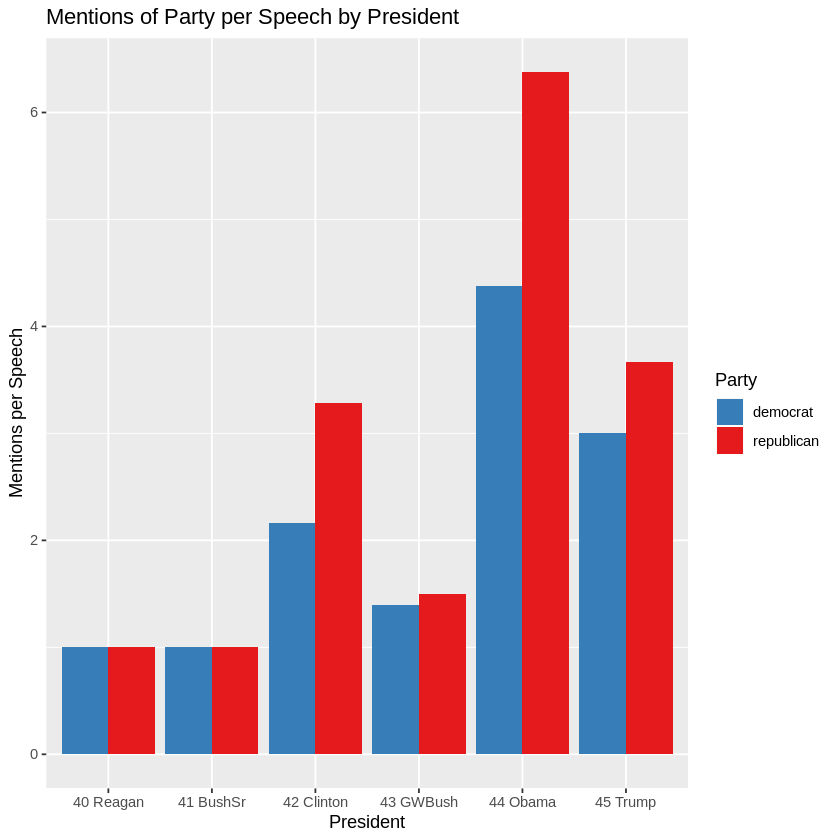

In [17]:
aboutOtherPresident %>%
  ggplot(aes(x=President, y=PerSpeech, fill=word)) +
  geom_bar(stat="identity", position="dodge") +
  scale_x_discrete(drop=FALSE) +
  scale_fill_brewer(palette="Set1", direction=-1, drop=FALSE) +
  labs(y="Mentions per Speech", fill="Party") +
  ggtitle("Mentions of Party per Speech by President")

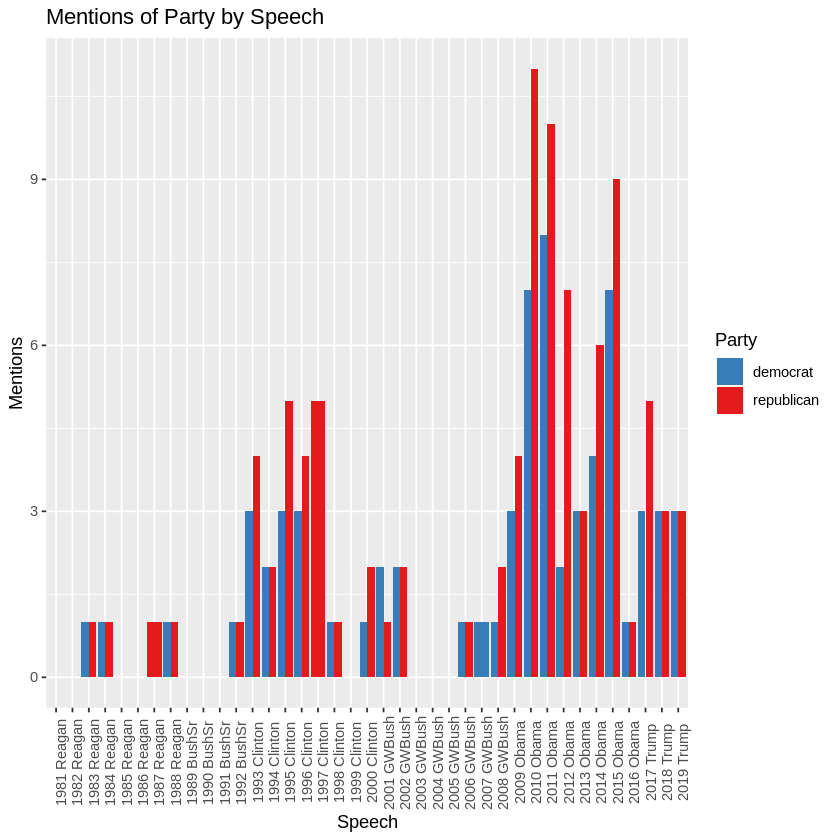

In [18]:
aboutOtherSpeech %>%
  ggplot(aes(x=Speech, y=Mentions, fill=word)) +
  geom_bar(stat="identity", position="dodge") +
  scale_x_discrete(breaks=factor(words$Speech), drop=FALSE) +
  scale_fill_brewer(palette="Set1", direction=-1, drop=FALSE) +
  labs(y="Mentions", fill="Party") +
  ggtitle("Mentions of Party by Speech") +
  theme(axis.text.x=element_text(angle=90))

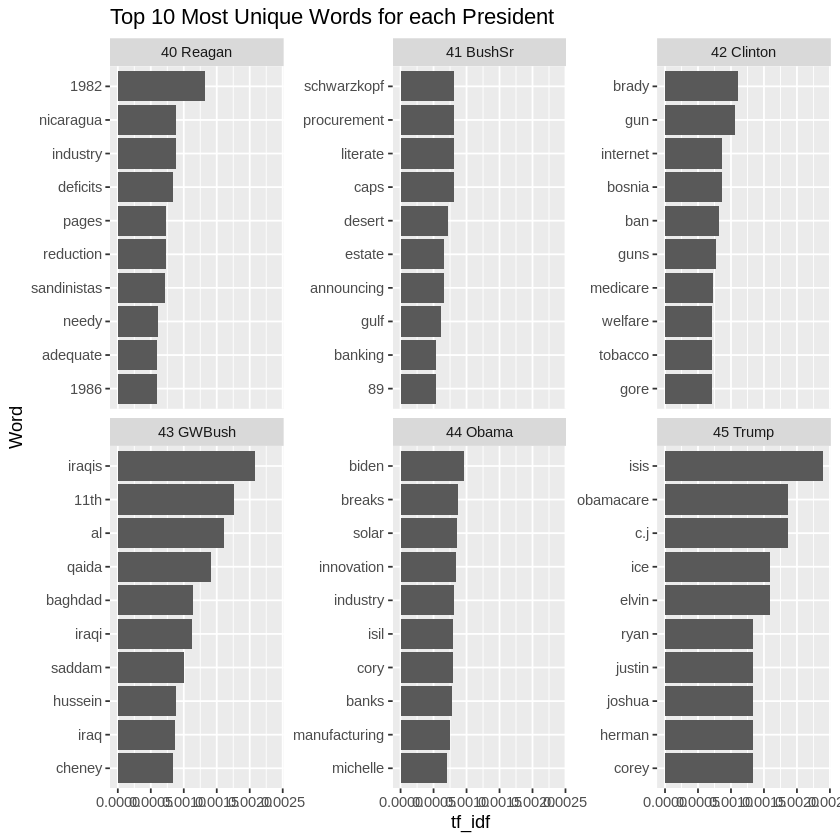

In [19]:
tfidfByPresident %>%
  group_by(President) %>%
  arrange(desc(tf_idf)) %>%
  filter(row_number() < 11) %>%
  ungroup() %>%
  ggplot(aes(x=reorder_within(word, tf_idf, President), y=tf_idf)) +
  geom_bar(stat="identity") +
  scale_x_reordered() +
  labs(x="Word") +
  facet_wrap(~ President, scales="free_y") +
  ggtitle("Top 10 Most Unique Words for each President") +
  coord_flip()

Selecting by tf_idf


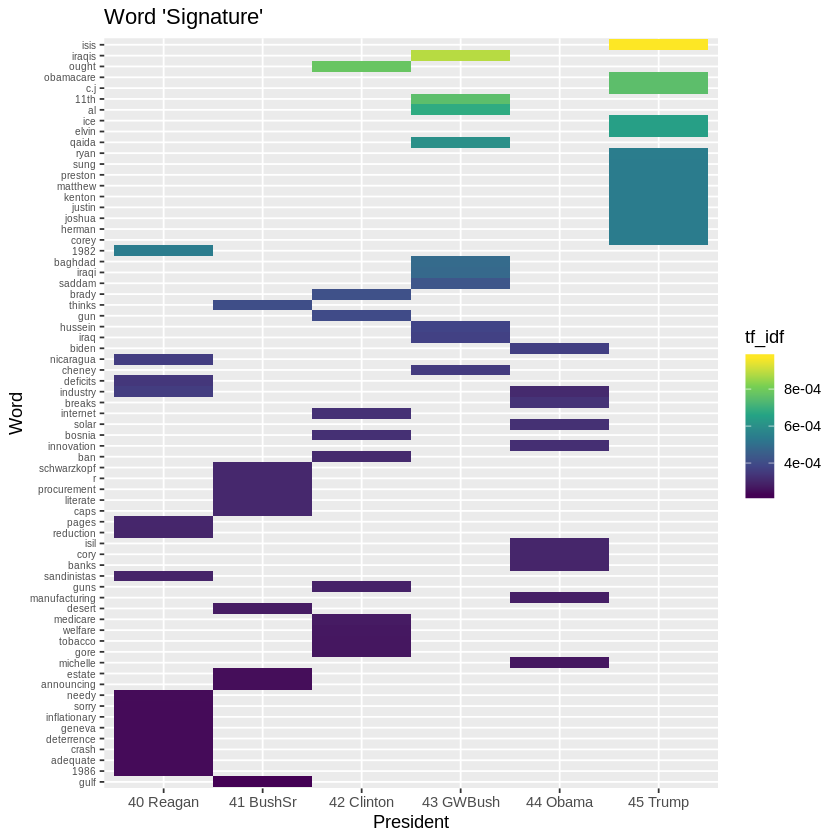

In [20]:
words %>%
  count(President, word, sort=TRUE) %>%
  bind_tf_idf(word, President, n) %>%
  group_by(President) %>%
  top_n(10) %>%
  ungroup() %>%
  arrange(desc(tf_idf)) %>%
  ggplot(aes(x=President, y=reorder(word, tf_idf), fill=tf_idf)) +
  geom_tile() +
  scale_fill_viridis_c() +
  labs(y="Word") +
  ggtitle("Word 'Signature'") +
  theme(axis.text.y=element_text(size=6))

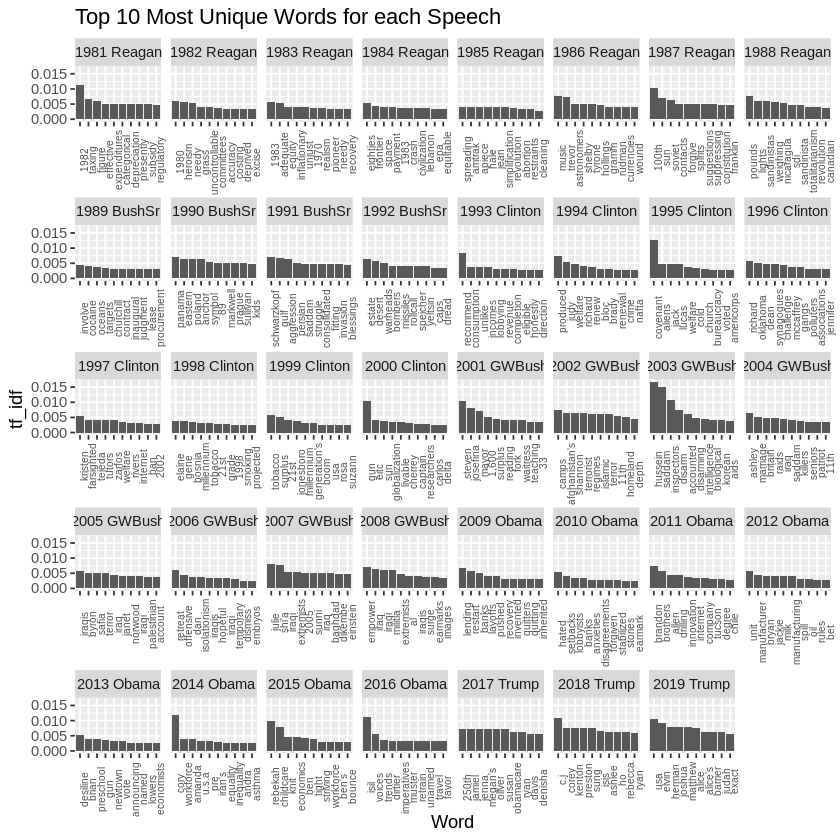

In [21]:
tfidfBySpeech %>%
  group_by(Speech) %>%
  arrange(desc(tf_idf)) %>%
  filter(row_number() < 11) %>%
  ungroup() %>%
  ggplot(aes(x=reorder_within(word, -tf_idf, Speech), y=tf_idf)) +
  geom_bar(stat="identity") +
  scale_x_reordered() +
  labs(x="Word") +
  facet_wrap(~ Speech, ncol=8, scales="free_x") +
  ggtitle("Top 10 Most Unique Words for each Speech") +
  theme(axis.text.x=element_text(angle=90, size=6))

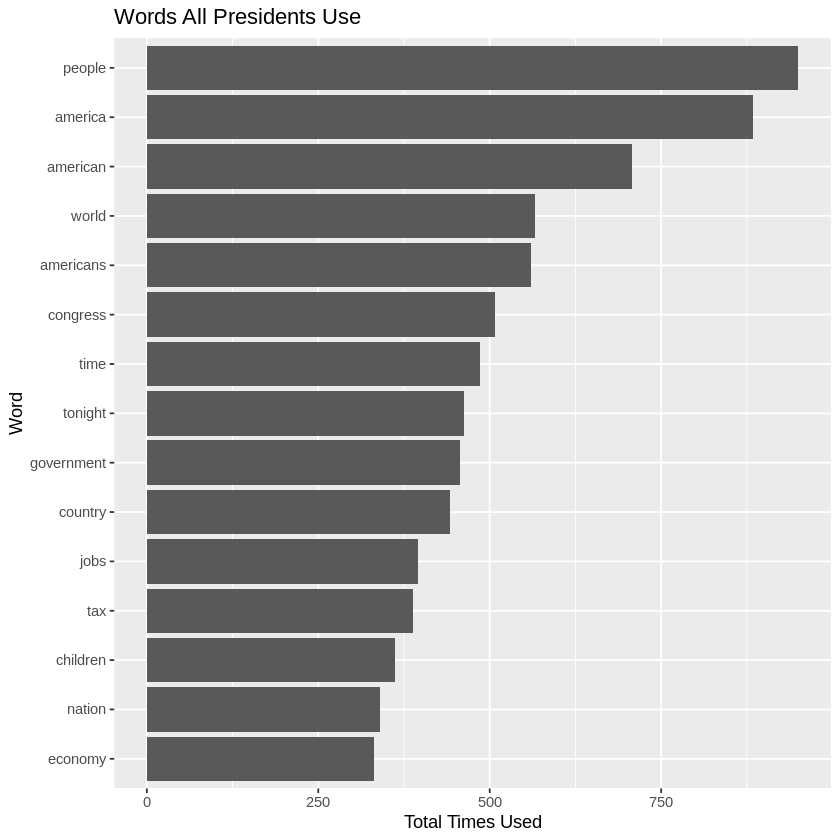

In [22]:
nonSpecificWords %>%
  head(15) %>%
  ggplot(aes(x=reorder(word, total), y=total)) +
  geom_bar(stat="identity") +
  labs(x="Word", y="Total Times Used") +
  ggtitle("Words All Presidents Use") +
  coord_flip()

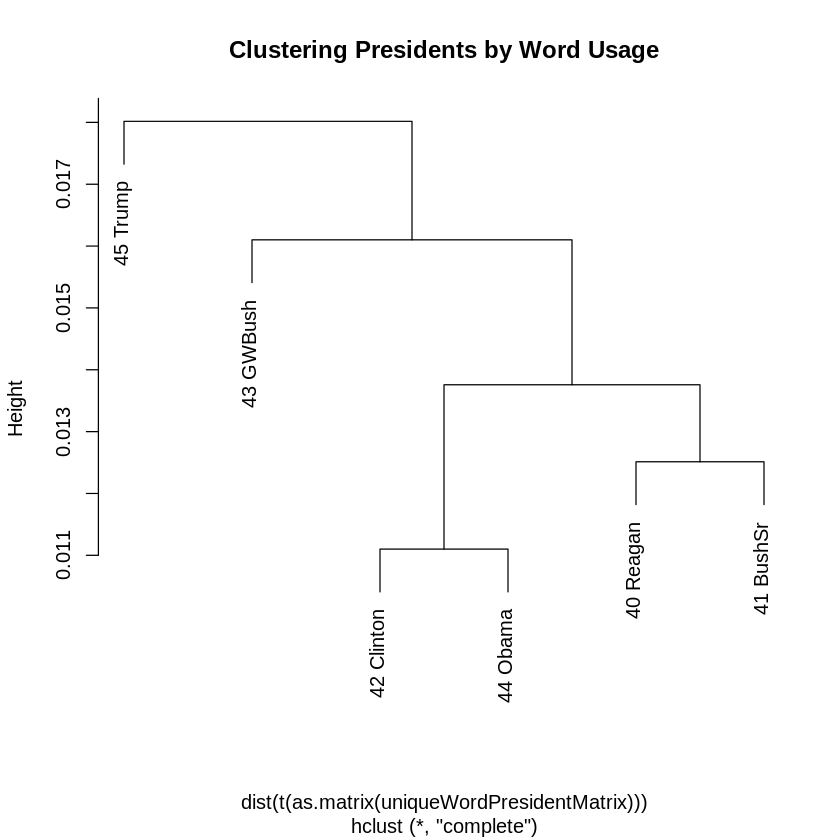

In [23]:
plot(presidentHC, main="Clustering Presidents by Word Usage")

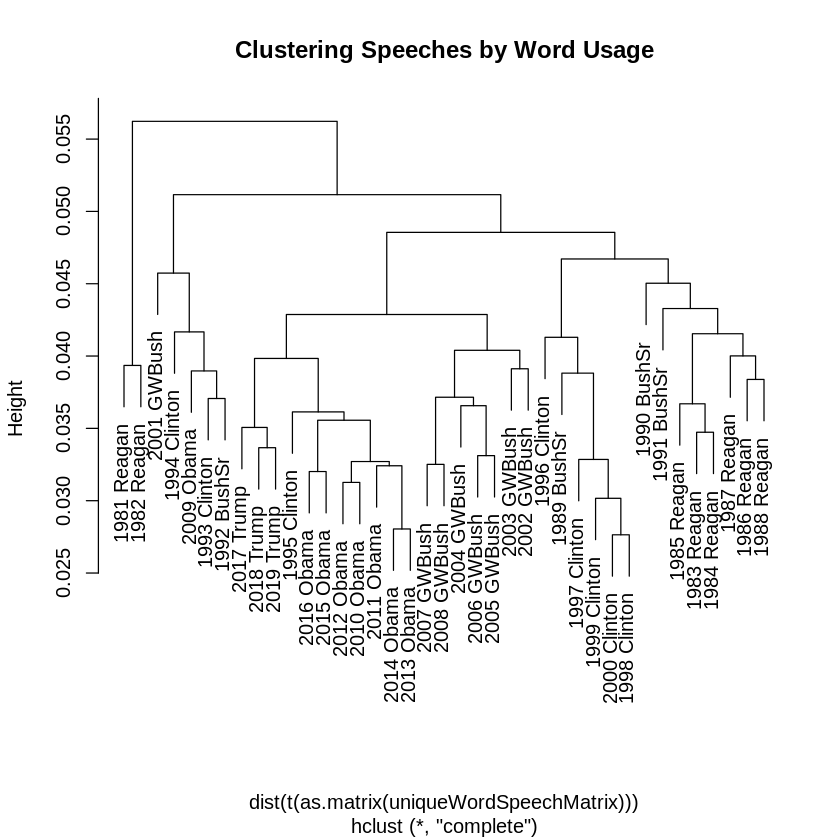

In [24]:
plot(speechHC, main="Clustering Speeches by Word Usage")

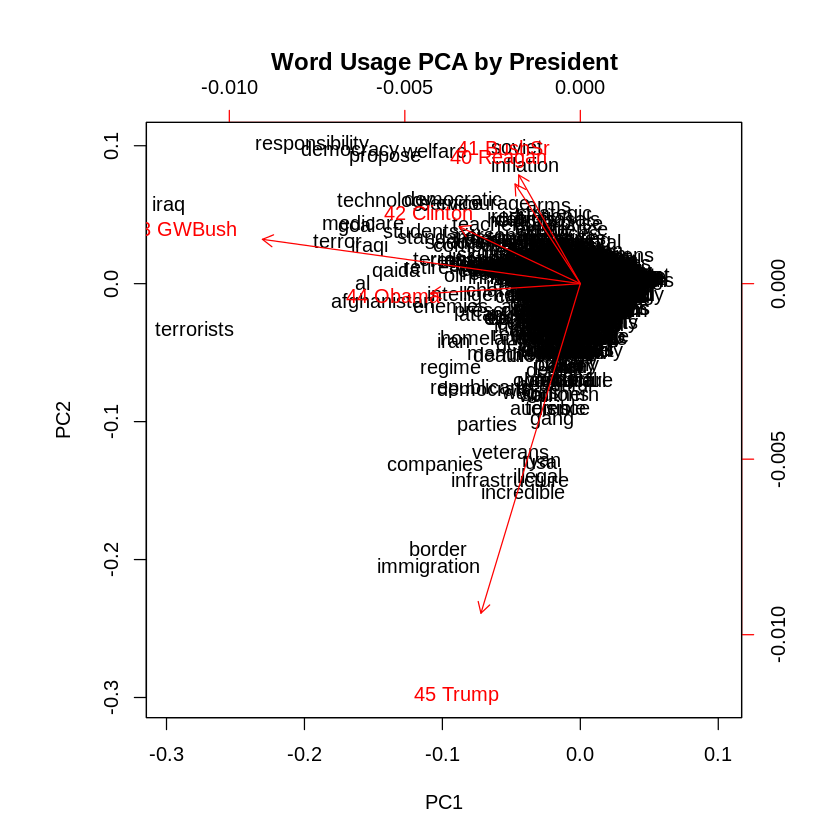

In [25]:
biplot(presidentPCA, main="Word Usage PCA by President")

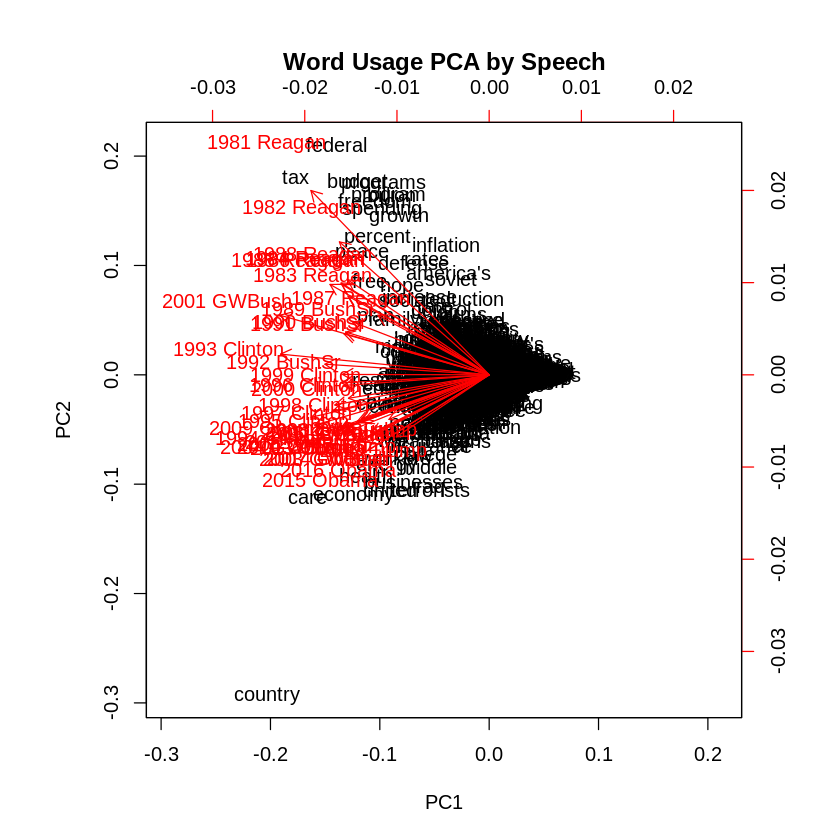

In [26]:
biplot(speechPCA, main="Word Usage PCA by Speech")